In [1]:
import os
from datetime import datetime
from collections import defaultdict
import numpy as np

import yaml
import sys
from easydict import EasyDict as edict

from IPython.core.debugger import set_trace

import torch
from torch import nn 
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tensorboardX import SummaryWriter

from networks import define_G, define_D, GANLoss, get_scheduler, update_learning_rate
from utils import vis_batch, save_batch, collate_fn, load_config
from dataset import FashionEdgesDataset
import matplotlib.pyplot as plt
from skimage.transform import resize
import cv2
from tensorboardX import SummaryWriter


def fig_to_array(fig):
    fig.canvas.draw()
    fig_image = np.array(fig.canvas.renderer._renderer)

    return fig_image

device = 'cuda:0'

In [2]:
from skimage.feature import canny
from skimage.morphology import dilation, disk, square
from skimage.color import rgb2gray
from skimage.filters import gaussian
from skimage.segmentation import flood

def image2edges(image, 
                low_thresh=0.01, 
                high_thresh=0.2, 
                sigma=0.5, 
                selem=True, 
                d = 2,
                randomize_disc=True):
        '''
        image - np.array
        '''
        image_gray_rescaled = rgb2gray(image)
        edges = canny(image_gray_rescaled, 
                      sigma = sigma, 
                      low_threshold=low_thresh, 
                      high_threshold=high_thresh)
        if selem:
            if randomize_disc:
                d = np.random.choice()
            selem = disk(d)
            edges = dilation(edges, selem)

2


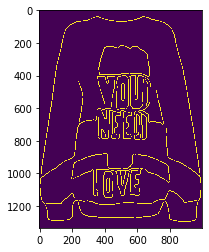

In [7]:
low_thresh=0.01 
high_thresh=0.2 
sigma=0.5
selem=True 
d = 2
randomize_disc=True

image = cv2.imread('./agata/Sweater/13783346_17197090_1000.png')

image_gray_rescaled = rgb2gray(image)
edges = canny(image_gray_rescaled, 
              sigma = 6, 
              low_threshold=low_thresh, 
              high_threshold=high_thresh)
if selem:
    if randomize_disc:
        d =  2 #np.random.choice([0,1,2,5], 1)
    selem = disk(d)
    edges = dilation(edges, selem)
print(d)    
plt.imshow(edges)    

In [8]:
edges.astype(float)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [4]:
module = nn.Conv2d(3,3,3)
optimizerG = optim.Adam(module.parameters(), lr=0.1, betas=(0.1, 0.999))

In [9]:
optimizerG.state_dict()['param_groups'][0]['lr']

0.1

In [39]:
writer = SummaryWriter('./logs/tmp')

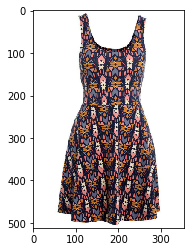

In [40]:
img = cv2.imread('./feidegger/images/8550.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = resize(img, (512,356), anti_aliasing=True)
fig = plt.figure()
plt.imshow(img)
arr = fig_to_array(fig)

In [46]:
n_iters_total = 10
writer.add_image(f"{n_iters_total}", arr[...,:3].transpose(2,0,1), global_step=n_iters_total)

In [4]:
netG = define_G(config.input_nc, config.output_nc, config.ngf, 'batch', False, 'normal', 0.02, gpu_id=device)
netD = define_D(config.input_nc + config.output_nc, config.ndf, 'basic', gpu_id=device)

initialize network with normal
initialize network with normal


In [6]:
s_total = 0
for param in netG.parameters():
    s_total+=param.numel()
print ('Params in Generator (M):', round(s_total/(10**6),2))

s_total = 0
for param in netD.parameters():
    s_total+=param.numel() 
print ('Params in Discriminator (M):', round(s_total/(10**6),2))


Params in Generator (M): 4.9
Params in Discriminator (M): 1.19


In [7]:
real_a, real_b = torch.randn(config.batch_size,1,512,356).cuda(), torch.randn(config.batch_size,3,512,356).cuda()
fake_b = netG(real_a)

In [8]:
fake_ab = torch.cat((real_a, fake_b), 1)
pred_fake = netD.forward(fake_ab)